# GNATS Reliability Analysis Demo
This is a demonstration of how the GNATS air traffic simulation can be used for reliability analysis.  The example makes use of the [PARA-ATM](https://github.com/ymlasu/para-atm) Python package to interface with GNATS, and the [UQpy](https://github.com/SURGroup/UQpy) package is used as the engine for uncertainty quantification and reliability analysis.

The problem being solved is purely for demonstration and is not intended to be realistic.  The primary objective is to illustrate a framework for integrating the GNATS simulation with a probabilistic toolset such as UQpy.

The problem employs a simulation with two aircraft that are both approaching the same arrival airport.  The basic idea is that the latitude and longitude coordinates for one of the waypoints for one of the aircraft are considered to be random variables.  The uncertainty in these waypoints creates uncertainty in the flight trajectories.  The response quantity of interest is taken to be the separation distance between the two aircraft at the final time point in the simulation.  The goal is to find the probability that this separation distance is below a given threshold.

To solve this problem using brute-force Monte Carlo sampling would require thousands of simulations to be executed.  In order to solve the problem more efficiently using a small number of simulations, we employ the Efficient Global Reliability Analysis (EGRA) method, which is available as `AKMCS` within UQpy.

![Flight trajectory](./trajectory.png)

## Prerequisites
This example requires:
* PARA-ATM Python package
* UQpy Python package
* NATS software (tested with NATS beta 1.8 on Linux; current TRX flight plan is not compatible with Open GNATS)

## Preliminaries
Several steps are required before we can set up the reliability analysis problem in UQpy.  First, we must create the flight plan and define the GNATS simulation.  The flight plan has been adapated from existing GNATS sample files and is based on earlier work by Yi Gao.  Then, the simulation itself is defined using the PARA-ATM NATS interface in the file [demo_2ac.py](demo_2ac.py) (technically the TRX flight plan is not currently compatible with Open GNATS, so this example actually uses NATS).  Here, a new class is derived from `NatsSimulationWrapper`, and the `simulation` method is written to accept the values of the input variables that we will need to vary duuring the reliability analysis (latitude and longitude coordinates for the waypoint).

UQpy provides the `RunModel` class for interfacing with simulations.  Currently, it is necessary to use the "Third-party software model" for running the NATS simulation as opposed to the "Python model".  Due to the fact that NATS simulations must be run within the NATS installation directory, this conflicts with the directory management done by UQpy when trying to run NATS from the same Python instance.  Thus, we use the "Third-party software model" interface instead.  This interface requires creating a thrid-party model execution script ([nats_driver.py](nats_driver.py)), a post-processing script ([nats_output_script.py](nats_output_script.py)), and a template input file ([nats_input.txt](nats_input.txt)).  Lastly, an additional script to coordinate execution of the simulation for UQpy is also required ([nats_uqpy_script.py](nats_uqpy_script.py)).

With these scripts in place to manage the simulation, we are now ready to set up and run the reliability analysis using UQpy.

## UQpy reliability analysis
We start out by importing the modules that we will be using from NumPy and UQpy.  From UQpy, we will use the following classes:
* `RunModel`: This is the class that is used to interface with the computational model
* `Normal`: This is the class used to create a normal probability distribution, which will be used for defining the input random variables
* `Kriging`: This defines the Kriging/GP surrogate model that is used by the AKMCS/EGRA reliability analysis method
* `AKMCS`, `LHS`, `MCS`: Classes for the various sampling methods that will be used in the analysis

Documentation for these and all other classes and methods available in UQpy is here: https://uqpyproject.readthedocs.io/en/latest/.

In [1]:
import numpy as np

from UQpy.RunModel import RunModel
from UQpy.Distributions import Normal
from UQpy.Surrogates import Kriging
from UQpy.SampleMethods import AKMCS, LHS, MCS

Next we create a `RunModel` instance, which will define how UQpy will interface to our simulation.  Here we simply pass in the names for the script that runs the model, the input file template, the variable names (which are referenced by the input file template), the output script, and the function within the output script that should be called to extract results:

In [2]:
model = RunModel(model_script='nats_uqpy_script.py',
                 input_template='nats_input.txt',
                 var_names=['latitude','longitude'],
                 output_script='nats_output_script.py',
                 output_object_name='get_output')

Next we define the input random variables.  For our example, the random variables are the latitude and longitude coordinates associated with a given waypoint for the first aircraft.  For demonstration purposes, we will assign them both normal distributions with a standard deviation of 1:

In [3]:
rvs = [Normal(31, 1), Normal(-85.0, 1)]

We must create an instance of the surrogate model class for use by UQpy in the `AKMCS` sampling method.  UQpy supports use of either its own Kriging surrogate model or the one provided by scikit-learn.  We will use the built-in UQpy Kriging class.  We define a constant trend function, the usual squared-exponential ("Gaussian") correlation function, and starting values for the correlation parameters:

In [4]:
surrogate = Kriging(reg_model='Constant', corr_model='Gaussian', corr_model_params = [1.0, 1.0])

We are now ready to run the AKMCS method in UQpy.  We will define the limit state value as a separation distance of `Z0 = 0.1` (this is for demonstration purposes only and is not physically meaningful).  The `AKMCS` class in UQpy is designed to accept the random variable deinition, the `RunModel` instance, the Kriging surrogate model instance, along with values for sample sizes and other options.  In principle, we should be able to use the `nstart` option to specify the number of initial samples to use, but there is a bug in the current version of the code (a bug report has been filed), so it is necssary to pass in the values of the initial samples.  We do this by generating the initial samples using the `LHS` method with a sample size of 6 (for repeatability, we also set the random seed using NumPy).

`AKMCS` is actually a general adapative sampling method that supports different "learning functions", one of which is the expected feasability function (EFF) used by the EGRA method.  We specify this via the `learning_function='EFF'` option.  This learning function has other required options that must be passed to the `AKMCS` init function:
* `eff_a`: The limit state value
* `eff_epsilon`: The $\varepsilon$ parameter in the EGRA algorithm.  Unfortunately, it appears that UQpy defines this in an aboslute sense, whereas the recommendation from the original EGRA paper is to use $\varepsilon = 2 \sigma_G(x)$, where $\sigma_G(x)$ is the GP prediction standard deviation.  For demonstration, we use a value of $\varepsilon=0.1$, but an issue or pull request should probably be submitted to UQpy for support of defining $\varepsilon$ in terms of $\sigma_G$.
* `eff_stop`: Stopping criterion for the EFF.  We use the same value reported in the original EGRA paper.

As soon as we call the `AKMCS` constructor, that will trigger the AKMCS algorithm to run.  It will collect simulation data, updating the Kriging surrogate model, until the EFF stopping criterion is met.  Note that UQpy will also create a directory structure (named as `Model_Runs*`) that will store copies of all input and output files for each run.

In [5]:
# Limit state value
Z0 = 0.1

nsamples = 15
# Generate the initial samples ourselves, due to UQpy bug with nstart (samples=None) input
np.random.seed(1)
lhs = LHS(rvs, nsamples)

method = AKMCS(rvs, model, surrogate, nsamples=nsamples, samples=lhs.samples,
               learning_function='EFF', eff_a=Z0, eff_epsilon=0.1, eff_stop=0.001)

Once the AKMCS method converges, the Kriging model instance `surrogate` contains the updated surrogate model.  We can inspect the sample input and output values (recall that 6 randomly chosen initial samples were used, and the remaining samples were selected based on maximization of the EFF):

In [6]:
print('Input samples:')
print(surrogate.samples)
print('Output samples:')
print(surrogate.values)

Input samples:
[[ 32.03097232 -86.8656758 ]
 [ 30.43700971 -83.37857645]
 [ 29.52050226 -85.75788431]
 [ 30.56932513 -84.77296229]
 [ 31.4990445  -84.36730856]
 [ 31.12664361 -85.25474185]]
Output samples:
[[2.17209473e-02]
 [2.14462525e-02]
 [7.70058751e-01]
 [4.20240459e-04]
 [3.13415537e-02]
 [2.39715588e-02]]


Next, we create a plot of the 2D response surface by leveraging the `ResponseModel` base class in PARA-ATM, which provides general plotting functionality.

Text(0.5, 0, 'Longitude')

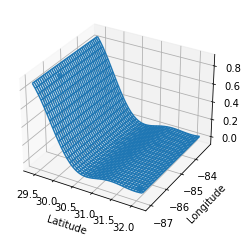

In [7]:
import matplotlib.pyplot as plt
from paraatm.rsm.base import ResponseSurface

# Create a class that derives from the `ResponseSurface` base class:
class UqpyKriging(ResponseSurface):
    def __init__(self, kriging):
        self.kriging = kriging
        super().__init__(kriging.samples, kriging.values)

    def __call__(self, X, return_stdev=False):
        if return_stdev:
            raise ValueError('not yet implemented')
        return self.kriging.predict(X)

# Create an instance and use the `surface_plot` method from the base class:
base_surrogate = UqpyKriging(surrogate)
base_surrogate.surface_plot()
plt.xlabel('Latitude')
plt.ylabel('Longitude')

Finally, we can use the converged Kriging surrogate model to efficiently estimate the probability of the separation distance falling below the given threshold using Monte Carlo sampling:

In [8]:
mcs = MCS(rvs, 100000)
preds = surrogate.predict(mcs.samples)
print('POF:', sum(preds[:,0]<Z0) / len(preds))

POF: 0.70697
